<a href="https://colab.research.google.com/github/louiewang820/car-condition-classification/blob/main/car_condition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#change directory to google drive
%cd /content/drive/MyDrive/
#make a directory named data_science_projects/car_condition
!mkdir data_science_projects
#change directory 
%cd data_science_projects

/content/drive/MyDrive
mkdir: cannot create directory ‘data_science_projects’: File exists
/content/drive/MyDrive/data_science_projects


In [ ]:
# clone data from github to your local machine, there are issues with directly cloning 
# !git clone https://github.com/louiewang820/car-condition-classification.git
# Then push it to the google drive 



In [ ]:
# change directory
%cd car-condition-classification

/content/drive/MyDrive/data_science_projects/car-condition-classification


# CNN

In [ ]:
import json
import numpy as np
import pandas as pd
from collections import OrderedDict
import torch
import torchvision
from torch import nn, optim
from torchvision import transforms, models, datasets
from torchsummary import summary
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from torchvision import utils
import matplotlib.pyplot as plt
import torchvision.models as models
from torch import nn, optim

In [ ]:
TRAIN_DIR = 'data/processed_data/train'
VALID_DIR = 'data/processed_data/valid'
BATCH_SIZE = 128
IMAGE_SIZE = 224

In [ ]:
def plot_batch(sample_batch, rgb=False):
  '''
  plot sample batch iamge
  '''
  plt.figure(figsize=(10, 8))
  plt.axis("off")
  plt.title("Sample Training Images")
  if rgb:
      plt.imshow(np.transpose(utils.make_grid(sample_batch, padding=1, normalize=True),(1,2,0)));
  else:
      plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1,2,0)));

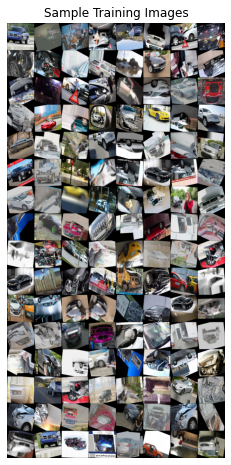

In [ ]:
# Load training data and create dataloaders

data_transforms = transforms.Compose([
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DIR,
                                                 transform=data_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           drop_last=False)
sample_batch, target = next(iter(train_loader))
plot_batch(sample_batch, rgb=True)

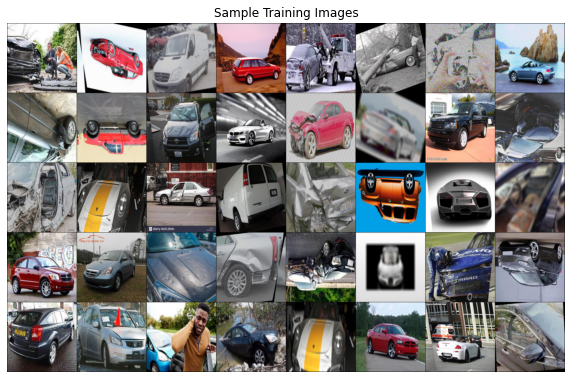

In [ ]:


# Load valid data and create dataloaders
data_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.ToTensor()
])

valid_dataset = torchvision.datasets.ImageFolder(root=VALID_DIR, transform=data_transforms)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
sample_batch, target = next(iter(valid_loader))
plot_batch(sample_batch, rgb=True)




In [ ]:

def trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    

    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        train_batch_acc = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        i = 0
        for X, y in train_loader:
            
            if device.type == 'cuda':
                X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X).flatten()
            y_hat_labels = torch.sigmoid(y_hat) > 0.5
            loss = criterion(y_hat, y.type(torch.float32))
            loss.backward()
            optimizer.step()
            train_batch_loss += loss.item()
            train_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()
            i +=1
            if i%5 ==0:
              print('Epoch [{}/{}], Step(iteration) [{}/{}], Loss: {:.6f}, Acc: {:.6f}'.format(
                  epoch + 1, epochs,i , len(train_loader), loss.item(), (y_hat_labels == y).type(torch.float32).mean().item()))

        
        # Validation
        model.eval()
        with torch.no_grad():
            for X, y in valid_loader:
                if device.type == 'cuda':
                    X, y = X.to(device), y.to(device)
                y_hat = model(X).flatten()
                y_hat_labels = torch.sigmoid(y_hat) > 0.5
                loss = criterion(y_hat, y.type(torch.float32))
                valid_batch_loss += loss.item()
                valid_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()
    
        train_accuracy.append(train_batch_acc / len(train_loader))
        valid_accuracy.append(valid_batch_acc / len(valid_loader))
        train_loss.append(train_batch_loss / len(train_loader))
        valid_loss.append(valid_batch_loss / len(valid_loader))
        model.train()
        
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Accuracy: {train_accuracy[-1]:.2f}",
                  f"Train Loss: {train_loss[-1]:.2f}",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}",
                  f"Valid Loss: {valid_loss[-1]:.2f}")
    
    return {"train_accuracy": train_accuracy, "valid_accuracy": valid_accuracy}
        
    


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=(5,5), padding= 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),

            torch.nn.Dropout(0.1),

            torch.nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(3,3), padding= 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),

            torch.nn.Conv2d(in_channels=10, out_channels=3, kernel_size=(3,3), padding= 1),
            torch.nn.ReLU(),

            torch.nn.Flatten(),
            torch.nn.Linear(9408, 2000),
            torch.nn.Linear(2000,1)
        )

    def forward(self,x):
        out = self.main(x)
        return out

In [ ]:
# GPU available?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")
# Model
model = CNN()
# model = models.alexnet()
# model.classifier[6] = nn.Linear(4096,1)
model.to(device)
criterion = nn.BCEWithLogitsLoss()

Using: cuda


In [ ]:
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 20, 224, 224]           1,520
              ReLU-2         [-1, 20, 224, 224]               0
         MaxPool2d-3         [-1, 20, 112, 112]               0
           Dropout-4         [-1, 20, 112, 112]               0
            Conv2d-5         [-1, 10, 112, 112]           1,810
              ReLU-6         [-1, 10, 112, 112]               0
         MaxPool2d-7           [-1, 10, 56, 56]               0
            Conv2d-8            [-1, 3, 56, 56]             273
              ReLU-9            [-1, 3, 56, 56]               0
          Flatten-10                 [-1, 9408]               0
           Linear-11                 [-1, 2000]      18,818,000
           Linear-12                    [-1, 1]           2,001
Total params: 18,823,604
Trainable params: 18,823,604
Non-trainable params: 0
-------------------------

In [ ]:
train_accuracy = []
train_loss = []
valid_loss = []
valid_accuracy = []

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), 0.00015)
results = trainer(model, criterion, optimizer, train_loader, valid_loader,device, epochs=55)

Epoch [1/55], Step(iteration) [5/20], Loss: 0.687563, Acc: 0.593750
Epoch [1/55], Step(iteration) [10/20], Loss: 0.691578, Acc: 0.593750
